In [11]:
#@title Input protein sequence(s), then hit `Runtime` -> `Run all`
#from google.colab import files
import os.path
import re
import hashlib
import random

def add_hash(x,y):
  return x+"_"+hashlib.sha1(y.encode()).hexdigest()[:5]

query_sequence = 'PIAQIHILEGRSDEQKETLIREVSEAISRSLDAPLTSVRVIITEMAKGHFGIGGELASK' #@param {type:"string"}
#@markdown  - Use `:` to specify inter-protein chainbreaks for **modeling complexes** (supports homo- and hetro-oligomers). For example **PI...SK:PI...SK** for a homodimer

# remove whitespaces
query_sequence = "".join(query_sequence.split())

jobname = 'test' #@param {type:"string"}
# remove whitespaces
basejobname = "".join(jobname.split())
basejobname = re.sub(r'\W+', '', basejobname)
jobname = add_hash(basejobname, query_sequence)
while os.path.isfile(f"colab_results/{jobname}.csv"):
  jobname = add_hash(basejobname, ''.join(random.sample(query_sequence,len(query_sequence))))

with open(f"colab_results/{jobname}.csv", "w") as text_file:
    text_file.write(f"id,sequence\n{jobname},{query_sequence}")

queries_path=f"colab_results/{jobname}.csv"

# number of models to use
use_amber = False #@param {type:"boolean"}
template_mode = "none" #@param ["none", "pdb70","custom"]
#@markdown - "none" = no template information is used, "pdb70" = detect templates in pdb70, "custom" - upload and search own templates (mmCIF format)

if template_mode == "pdb70":
  use_templates = True
  custom_template_path = None
elif template_mode == "custom":
  from google.colab import files
  custom_template_path = f"{jobname}_template"
  os.mkdir(custom_template_path)
  uploaded = files.upload()
  use_templates = True
  for fn in uploaded.keys():
    os.rename(fn, f"{jobname}_template/{fn}")
else:
  custom_template_path = None
  use_templates = False


In [12]:
#@markdown ### MSA options (custom MSA upload, single sequence, pairing mode)
msa_mode = "MMseqs2 (UniRef+Environmental)" #@param ["MMseqs2 (UniRef+Environmental)", "MMseqs2 (UniRef only)","single_sequence","custom"]
pair_mode = "unpaired+paired" #@param ["unpaired+paired","paired","unpaired"] {type:"string"}
#@markdown - "unpaired+paired" = pair sequences from same species + unpaired MSA, "unpaired" = seperate MSA for each chain, "paired" - only use paired sequences.

# decide which a3m to use
if msa_mode.startswith("MMseqs2"):
  a3m_file = f"colab_results/{jobname}.a3m"
elif msa_mode == "custom":
  a3m_file = f"colab_results/{jobname}.custom.a3m"
  if not os.path.isfile(a3m_file):
    from google.colab import files
    custom_msa_dict = files.upload()
    custom_msa = list(custom_msa_dict.keys())[0]
    header = 0
    import fileinput
    for line in fileinput.FileInput(custom_msa,inplace=1):
      if line.startswith(">"):
         header = header + 1
      if not line.rstrip():
        continue
      if line.startswith(">") == False and header == 1:
         query_sequence = line.rstrip()
      print(line, end='')

    os.rename(custom_msa, a3m_file)
    queries_path=a3m_file
    print(f"moving {custom_msa} to {a3m_file}")
else:
  a3m_file = f"colab_results/{jobname}.single_sequence.a3m"
  with open(a3m_file, "w") as text_file:
    text_file.write(">1\n%s" % query_sequence)

In [13]:
#@markdown ### Advanced settings
model_type = "auto" #@param ["auto", "AlphaFold2-ptm", "AlphaFold2-multimer-v1", "AlphaFold2-multimer-v2"]
num_recycles = 3 #@param [1,3,6,12,24,48] {type:"raw"}
#@markdown  - "auto" = protein structure prediction using "AlphaFold2-ptm" and complex prediction "AlphaFold-multimer-v2". For complexes "AlphaFold-multimer-v[1,2]" and "AlphaFold-ptm" can be used.
save_to_google_drive = False #@param {type:"boolean"}

In [17]:
#!pip install colabfold
# !conda install -y -q -c conda-forge -c bioconda colabfold openmm=7.5.1 kalign2=2.04 hhsuite=3.3.0 pdbfixer jax

In [18]:
'''%%bash -s $use_amber $use_templates

set -e

USE_AMBER=$1
USE_TEMPLATES=$2

if [ ! -f COLABFOLD_READY ]; then
  # install dependencies
  # We have to use "--no-warn-conflicts" because colab already has a lot preinstalled with requirements different to ours
  pip install --no-warn-conflicts -q "colabfold[alphafold] @ git+https://github.com/sokrypton/ColabFold"
  touch COLABFOLD_READY
fi

# setup conda
if [ ${USE_AMBER} == "True" ] || [ ${USE_TEMPLATES} == "True" ]; then
  if [ ! -f CONDA_READY ]; then
    wget -qnc https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
    bash Miniconda3-latest-Linux-x86_64.sh -bfp /usr/local 2>&1 1>/dev/null
    rm Miniconda3-latest-Linux-x86_64.sh
    touch CONDA_READY
  fi
fi
# setup template search
if [ ${USE_TEMPLATES} == "True" ] && [ ! -f HH_READY ]; then
  conda install -y -q -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 2>&1 1>/dev/null
  touch HH_READY
fi
# setup openmm for amber refinement
if [ ${USE_AMBER} == "True" ] && [ ! -f AMBER_READY ]; then
  conda install -y -q -c conda-forge openmm=7.5.1 pdbfixer 2>&1 1>/dev/null
  wget -qnc https://raw.githubusercontent.com/deepmind/alphafold/main/docker/openmm.patch
  (cd /usr/local/lib/python3.9/site-packages; patch -s -p0 < /content/openmm.patch)
  wget -qnc https://git.scicore.unibas.ch/schwede/openstructure/-/raw/7102c63615b64735c4941278d92b554ec94415f8/modules/mol/alg/src/stereo_chemical_props.txt
  touch AMBER_READY
fi'''

'%%bash -s $use_amber $use_templates\n\nset -e\n\nUSE_AMBER=$1\nUSE_TEMPLATES=$2\n\nif [ ! -f COLABFOLD_READY ]; then\n  # install dependencies\n  # We have to use "--no-warn-conflicts" because colab already has a lot preinstalled with requirements different to ours\n  pip install --no-warn-conflicts -q "colabfold[alphafold] @ git+https://github.com/sokrypton/ColabFold"\n  touch COLABFOLD_READY\nfi\n\n# setup conda\nif [ ${USE_AMBER} == "True" ] || [ ${USE_TEMPLATES} == "True" ]; then\n  if [ ! -f CONDA_READY ]; then\n    wget -qnc https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh\n    bash Miniconda3-latest-Linux-x86_64.sh -bfp /usr/local 2>&1 1>/dev/null\n    rm Miniconda3-latest-Linux-x86_64.sh\n    touch CONDA_READY\n  fi\nfi\n# setup template search\nif [ ${USE_TEMPLATES} == "True" ] && [ ! -f HH_READY ]; then\n  conda install -y -q -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 2>&1 1>/dev/null\n  touch HH_READY\nfi\n# setup openmm for amber refinement\

In [1]:
!pip uninstall -y colabfold[alphafold] #jax[cuda11_cudnn82]
!pip uninstall -y colabfold #jax[cuda11_cudnn82]

Found existing installation: colabfold 1.2.0
Uninstalling colabfold-1.2.0:
  Successfully uninstalled colabfold-1.2.0


In [52]:
!pip install --upgrade pip
#!pip uninstall -y jax[cuda11_cudnn82]

In [15]:
#!pip install "colabfold[alphafold] @ git+https://github.com/sokrypton/ColabFold"
#!pip install "colabfold[alphafold] @ git+https://github.com/sokrypton/ColabFold"

In [4]:
#### It works ####
#!pip install "colabfold[alphafold] @ git+https://github.com/sokrypton/ColabFold"
!pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_releases.html  # Note: wheels only available on linux.
!pip install "colabfold @ git+https://github.com/sokrypton/ColabFold"

Looking in links: https://storage.googleapis.com/jax-releases/jax_releases.html
     |████████████████████████████████| 155.5 MB 384 kB/s eta 0:00:011
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.3.2
    Uninstalling jaxlib-0.3.2:
      Successfully uninstalled jaxlib-0.3.2
  Cloning https://github.com/sokrypton/ColabFold to /data/jwd/main/043/082/43082610/tmp/pip-install-dhdigxwl/colabfold_375b2bf399c84b8f8764e691a183b2e3
  Running command git clone -q https://github.com/sokrypton/ColabFold /data/jwd/main/043/082/43082610/tmp/pip-install-dhdigxwl/colabfold_375b2bf399c84b8f8764e691a183b2e3
  Resolved https://github.com/sokrypton/ColabFold to commit 48d1771ccfcf3580f8e4d03df7af44163241834f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [ ]:
#!pip install jax[cuda11_cudnn82]
#!pip install jax[cuda11_cudnn82] -f https://storage.googleapis.com/jax-releases/jax_releases.html
!pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_releases.html  # Note: wheels only available on linux.

#### It works
#!pip install --upgrade "jax[cpu]"

In [8]:
!pip install jax[cuda11_cudnn82] -f https://storage.googleapis.com/jax-releases/jax_releases.html

Looking in links: https://storage.googleapis.com/jax-releases/jax_releases.html


In [6]:
#!pip install tfp-nightly[jax]

In [9]:
import tensorflow as tf
gpu = tf.config.list_physical_devices('GPU')
gpu, tf.__version__

([], '2.7.1')

In [10]:
#import colabfold

In [11]:
#import jax

In [ ]:
#@title Run Prediction

import sys
import colabfold

from colabfold.download import download_alphafold_params, default_data_dir
from colabfold.utils import setup_logging
from colabfold.batch import get_queries, run, set_model_type

K80_chk = !nvidia-smi | grep "Tesla K80" | wc -l
if "1" in K80_chk:
  print("WARNING: found GPU Tesla K80: limited to total length < 1000")
  if "TF_FORCE_UNIFIED_MEMORY" in os.environ:
    del os.environ["TF_FORCE_UNIFIED_MEMORY"]
  if "XLA_PYTHON_CLIENT_MEM_FRACTION" in os.environ:
    del os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]


from colabfold.colabfold import plot_protein
from pathlib import Path
import matplotlib.pyplot as plt


# For some reason we need that to get pdbfixer to import
#if use_amber and '/usr/local/lib/python3.7/site-packages/' not in sys.path:
#    sys.path.insert(0, '/usr/local/lib/python3.7/site-packages/')

def prediction_callback(unrelaxed_protein, length, prediction_result, input_features):
  fig = plot_protein(unrelaxed_protein, Ls=length, dpi=100)
  plt.show()
  plt.close()

result_dir="colab_results/"
setup_logging(Path("colab_results/").joinpath("log.txt"))
queries, is_complex = get_queries(queries_path)

model_type = set_model_type(is_complex, model_type)

download_alphafold_params(model_type, Path("colab_results"))

run(
    queries=queries,
    result_dir=result_dir,
    use_templates=use_templates,
    custom_template_path=custom_template_path,
    use_amber=use_amber,
    msa_mode=msa_mode,
    model_type=model_type,
    num_models=5,
    num_recycles=num_recycles,
    model_order=[1, 2, 3, 4, 5],
    is_complex=is_complex,
    data_dir=Path("colab_results"),
    keep_existing_results=False,
    recompile_padding=1.0,
    rank_by="auto",
    pair_mode=pair_mode,
    stop_at_score=float(100),
    prediction_callback=prediction_callback,
)

2022-03-22 15:23:38,589 Running colabfold 1.2.0 (48d1771ccfcf3580f8e4d03df7af44163241834f)
2022-03-22 15:23:38,890 Found 5 citations for tools or databases
2022-03-22 15:23:47,234 Query 1/1: test_4262f (length 59)


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:03 remaining: 00:00]


2022-03-22 15:23:51,056 Running model_1


In [18]:
#@title Display 3D structure {run: "auto"}
import py3Dmol
import glob
import matplotlib.pyplot as plt
rank_num = 1 #@param ["1", "2", "3", "4", "5"] {type:"raw"}
color = "lDDT" #@param ["chain", "lDDT", "rainbow"]
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}

jobname_prefix = ".custom" if msa_mode == "custom" else ""
if use_amber:
  pdb_filename = f"colab_results/{jobname}{jobname_prefix}_relaxed_rank_{rank_num}_model_*.pdb"
else:
  pdb_filename = f"colab_results/{jobname}{jobname_prefix}_unrelaxed_rank_{rank_num}_model_*.pdb"

pdb_file = glob.glob(pdb_filename)

def show_pdb(rank_num=1, show_sidechains=False, show_mainchains=False, color="lDDT"):
  model_name = f"rank_{rank_num}"
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
  view.addModel(open(pdb_file[0],'r').read(),'pdb')

  if color == "lDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':50,'max':90}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    chains = len(queries[0][1]) + 1 if is_complex else 1
    for n,chain,color in zip(range(chains),list("ABCDEFGH"),
                     ["lime","cyan","magenta","yellow","salmon","white","blue","orange"]):
      view.setStyle({'chain':chain},{'cartoon': {'color':color}})
  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                        {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})  
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})

  view.zoomTo()
  return view


show_pdb(rank_num,show_sidechains, show_mainchains, color).show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol


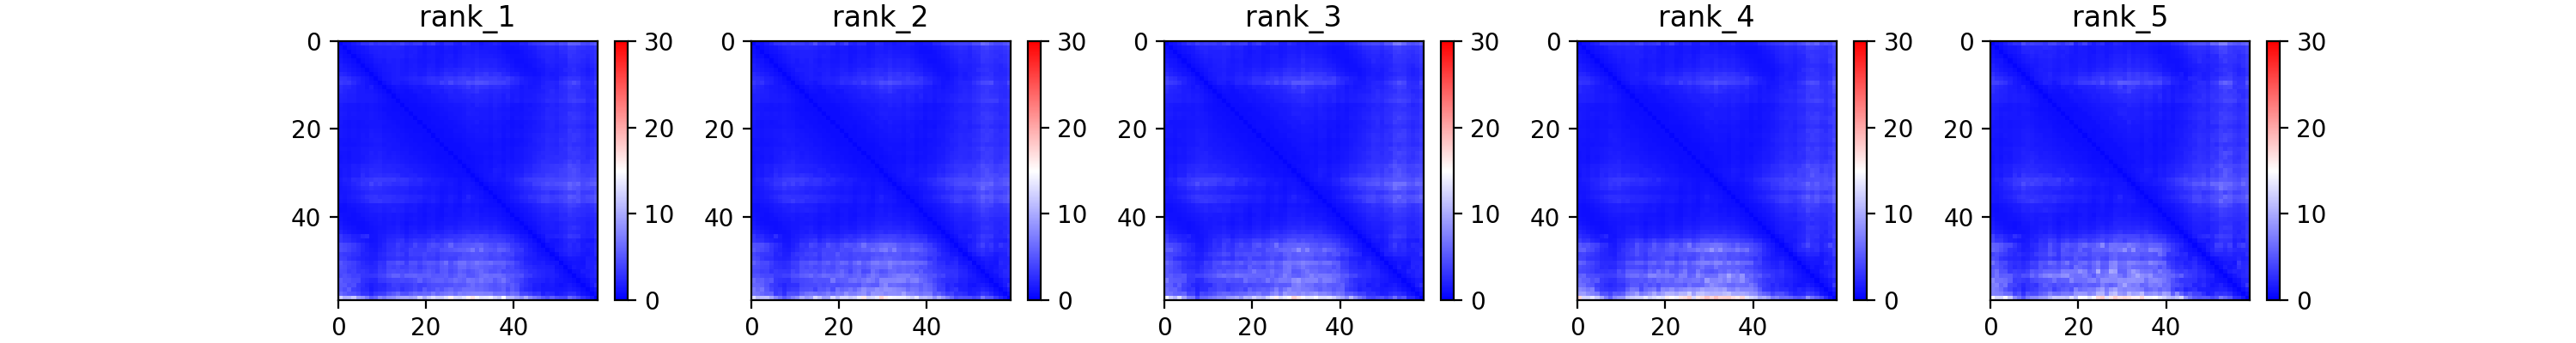
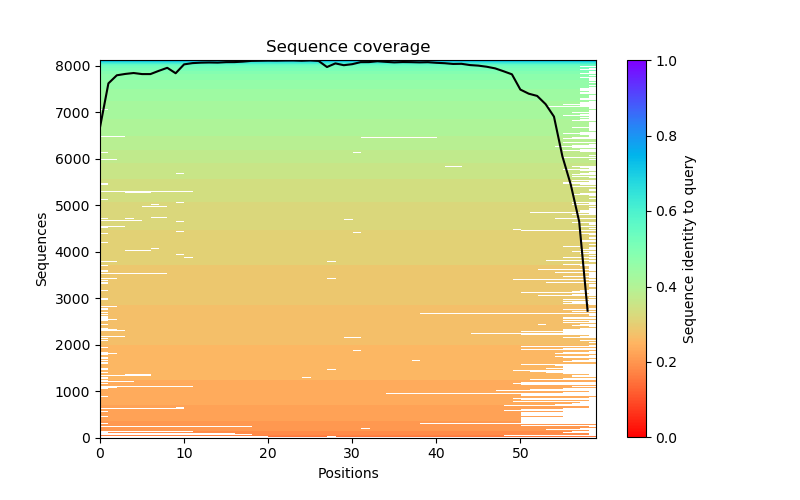
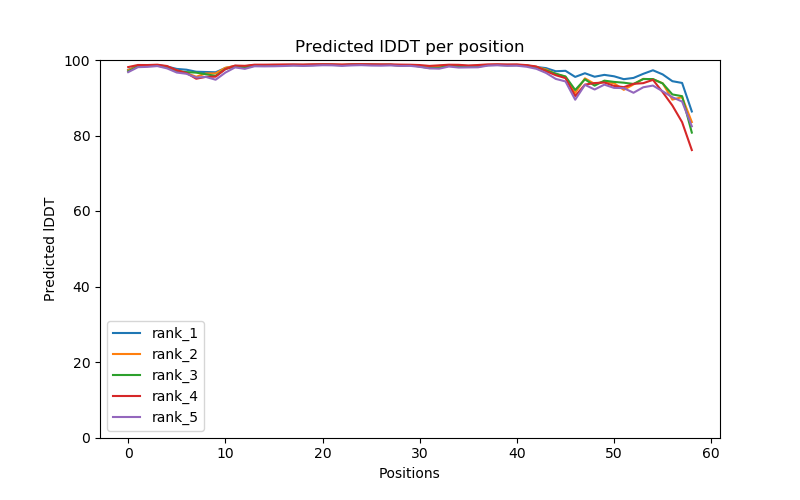

In [20]:
#@title Plots {run: "auto"}
from IPython.display import display, HTML
import base64
from html import escape

# see: https://stackoverflow.com/a/53688522
def image_to_data_url(filename):
  ext = filename.split('.')[-1]
  prefix = f'data:image/{ext};base64,'
  with open(filename, 'rb') as f:
    img = f.read()
  return prefix + base64.b64encode(img).decode('utf-8')

pae = image_to_data_url(f"colab_results/{jobname}{jobname_prefix}_PAE.png")
cov = image_to_data_url(f"colab_results/{jobname}{jobname_prefix}_coverage.png")
plddt = image_to_data_url(f"colab_results/{jobname}{jobname_prefix}_plddt.png")
display(HTML(f"""
<style>
  img {{
    float:left;
  }}
  .full {{
    max-width:100%;
  }}
  .half {{
    max-width:50%;
  }}
  @media (max-width:640px) {{
    .half {{
      max-width:100%;
    }}
  }}
</style>
<div style="max-width:90%; padding:2em;">
  <h1>Plots for {escape(jobname)}</h1>
  <img src="{pae}" class="full" />
  <img src="{cov}" class="half" />
  <img src="{plddt}" class="half" />
</div>
"""))
